In [1]:
import math
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import time
import routing
from routing import VRPInstance, VRPModel
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from heapq import heappush, heappop

In [2]:
num_customers = 30
data_df = pd.read_csv('data.dat', sep='\s+')
data_dict_rows = data_df.to_dict(orient='records')
locations = {row['CUST_NO'] : row for row in data_dict_rows if row['CUST_NO'] <= num_customers}
depot = 1
cost_per_mile = 1
avg_speed = 1 # miles per hour
n = len(locations)

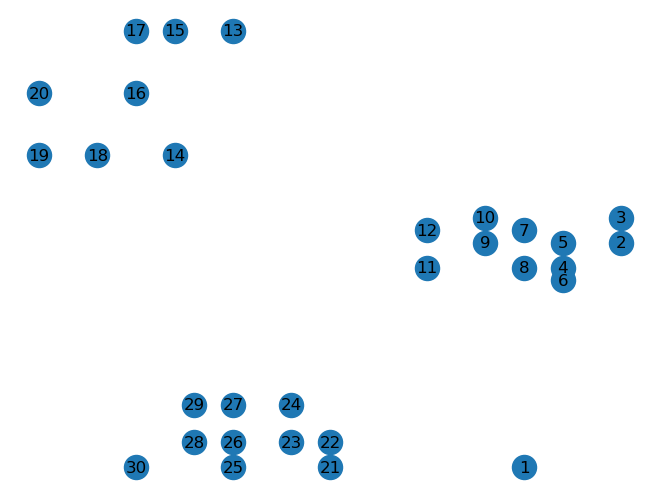

In [3]:
routing.show_tours([], locations, to_tikz=True, tikz_file_name='customers.tex')

In [4]:
instance = routing.TSPInstance(data_file = 'data.dat', 
                    num_customers = num_customers,
                    average_speed=1,
                    cost_per_mile=1)

# TSP

In [5]:
tsp = routing.TSPModel(instance)
m = tsp.create_gurobi_tsp_model() # MTZ formulation (Big M)

routing.solve_model(m)

Set parameter Username


Academic license - for non-commercial use only - expires 2025-12-05

Interrupt request received
Optimal objective value: 147
Optimization time: 7.825 seconds


In [ ]:
edges_used_gurobi = [(i, j) for i, j in instance.edges if m._x[i, j].x > 0.5]
tour = routing.get_tour_from_edges_used(edges_used_gurobi)
print("complete tour", tour)
print("cost", routing.get_cost_of_tour(tour, instance.edge_costs))

complete tour [1, 8, 6, 4, 2, 3, 5, 7, 10, 9, 11, 12, 13, 15, 17, 16, 20, 19, 18, 14, 24, 27, 29, 28, 30, 25, 26, 23, 22, 21, 1]
cost 144


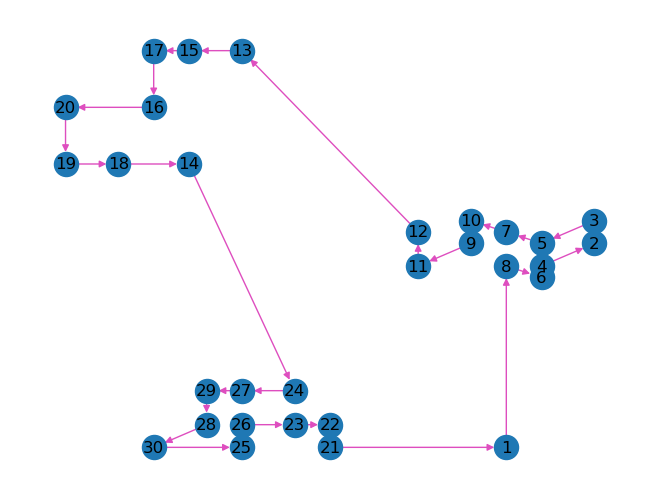

In [ ]:
routing.show_tours([edges_used_gurobi], locations, to_tikz = True, tikz_file_name = "tsp.tex")

# TSP: Solve via Callbacks

In [ ]:
instance = routing.TSPInstance(data_file = 'data.dat', 
                    num_customers = num_customers,
                    average_speed=1,
                    cost_per_mile=1)
tsp = routing.TSPModel(instance)
result = tsp.optimize_with_callbacks(log = True)

Set parameter LazyConstraints to value 1


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 24.0.0 24A335)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 60 rows, 900 columns and 1740 nonzeros
Model fingerprint: 0x7690e382
Variable types: 0 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
new incumbent: [(1, 6), (2, 18), (3, 17), (4, 23), (5, 27), (6, 19), (7, 2), (8, 12), (9, 24), (10, 22), (11, 9), (12, 4), (13, 20), (14, 11), (15, 1), (16, 26), (17, 21), (18, 10), (19, 5), (20, 8), (21, 15), (22, 7), (23, 25), (24, 30), (25, 14), (26, 13), (27, 29), (28, 16), (29, 3), (30, 28)]
subtour node subset [22, 7, 2, 18, 10]
Presolve time: 0.00s
Presolved: 60 rows, 900 columns, 1740 nonzeros
Variable types: 0 continuous, 900 integer (900 binary)
new incumbent: [(1, 21), (2, 3), (3, 2)

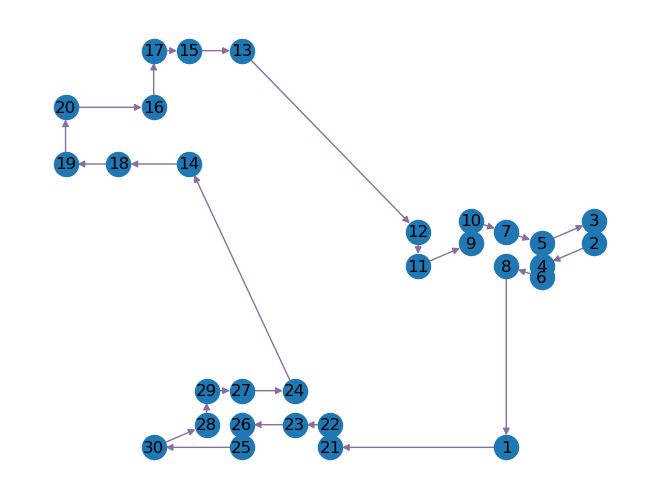

In [ ]:
edges_used = result['edges_used']
routing.show_tours([edges_used], instance.locations, to_tikz = True, tikz_file_name = "tsp-callbacks.tex")

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 24.0.0 24A335)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 200 rows, 10000 columns and 19800 nonzeros
Model fingerprint: 0xc3969b6d
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
new incumbent: [(1, 27), (2, 96), (3, 78), (4, 58), (5, 42), (6, 36), (7, 99), (8, 67), (9, 89), (10, 80), (11, 5), (12, 76), (13, 62), (14, 68), (15, 18), (16, 93), (17, 33), (18, 94), (19, 52), (20, 29), (21, 40), (22, 19), (23, 47), (24, 82), (25, 85), (26, 15), (27, 46), (28, 44), (29, 12), (30, 2), (31, 65), (32, 86), (33, 100), (34, 49), (35, 39), (36, 7), (37, 92), (38, 88), (39, 64), (40, 35), (41, 6), (42, 26), (43, 25), (44, 10), (45, 3

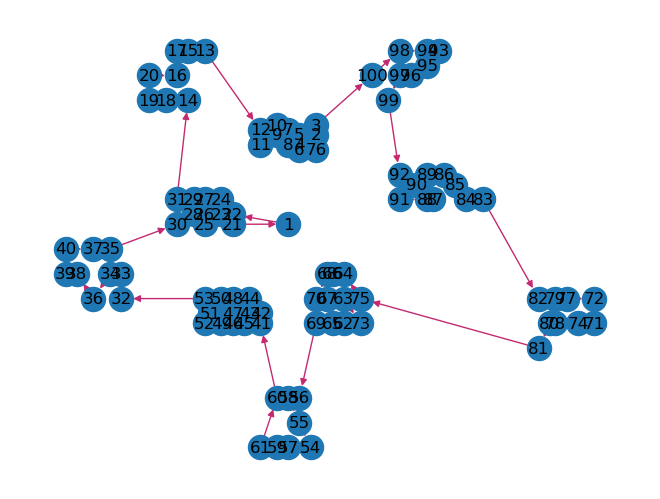

In [ ]:
instance = routing.TSPInstance(data_file = 'data.dat', 
                    num_customers = 100,
                    average_speed=1,
                    cost_per_mile=1)
tsp = routing.TSPModel(instance)
result = tsp.optimize_with_callbacks(log = True)
edges_used = result['edges_used']
routing.show_tours([edges_used], instance.locations, to_tikz = True, tikz_file_name = "tsp-callbacks.tex")

# TSP Relaxation with Rounding

In [ ]:
#m = routing.create_tsp_model(depot, instance.nodes, instance.edge_costs, relaxed=True)
m = tsp.create_gurobi_tsp_model(relaxed=True)
routing.solve_model(m)
edges_used_adjacency_list= {i : {j : m._x[i, j].x for j in instance.nodes} for i in instance.nodes}
for i in edges_used_adjacency_list:
    for j in edges_used_adjacency_list[i]:
        if edges_used_adjacency_list[i][j] > 0.01:
            print((i,j), edges_used_adjacency_list[i][j])

Optimal objective value: 324
Optimization time: 0.047 seconds
(1, 21) 1.0
(2, 3) 0.99
(2, 76) 0.010000000000000009
(3, 2) 0.99
(3, 5) 0.010000000000000009
(4, 6) 0.020000000000000018
(4, 8) 0.98
(5, 7) 0.99
(5, 8) 0.010000000000000009
(6, 8) 0.010000000000000009
(6, 76) 0.99
(7, 5) 0.99
(7, 10) 0.010000000000000009
(8, 4) 1.0
(9, 10) 0.99
(9, 11) 0.010000000000000009
(10, 7) 0.010000000000000009
(10, 9) 0.98
(10, 12) 0.010000000000000009
(11, 9) 0.010000000000000009
(11, 12) 0.99
(12, 9) 0.010000000000000009
(12, 11) 0.99
(13, 15) 0.99
(13, 17) 0.010000000000000009
(14, 16) 0.010000000000000009
(14, 18) 0.99
(15, 13) 0.010000000000000009
(15, 17) 0.99
(16, 14) 0.99
(16, 20) 0.010000000000000009
(17, 13) 0.99
(17, 15) 0.010000000000000009
(18, 14) 0.010000000000000009
(18, 19) 0.99
(19, 18) 0.010000000000000009
(19, 20) 0.99
(20, 16) 0.99
(20, 19) 0.010000000000000009
(21, 1) 0.99
(21, 22) 0.010000000000000009
(22, 1) 0.010000000000000009
(22, 23) 0.99
(23, 22) 0.99
(23, 24) 0.010000000

In [ ]:
rounded_tour = routing.round_tsp_solution(edges_used_adjacency_list, n, log = False)
print("rounded_tour", rounded_tour)
complete_rounded = routing.complete_tour(rounded_tour)
print("cost", routing.get_cost_of_tour(complete_rounded, 
                                       instance.edge_costs))

rounded_tour [1, 21, 22, 23, 24, 27, 29, 31, 30, 28, 25, 26, 2, 3, 5, 7, 10, 9, 11, 12, 4, 8, 6, 76, 13, 15, 17, 14, 18, 19]
cost 183


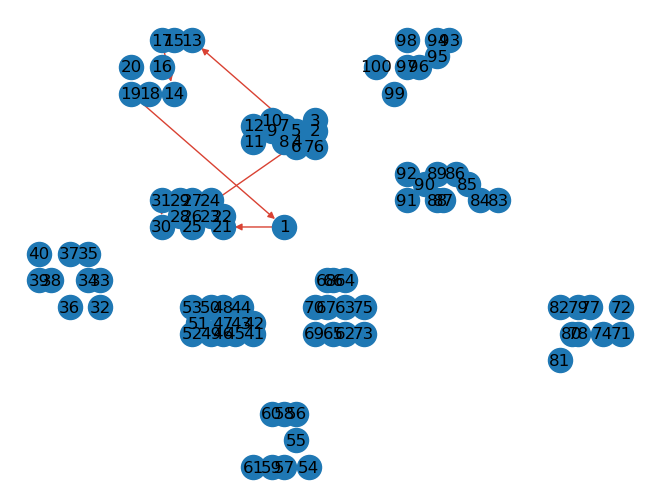

In [ ]:
edges_used_rounded = routing.get_edges_used_from_tour(complete_rounded)
routing.show_tours([edges_used_rounded], instance.locations, to_tikz = True, 
                   tikz_file_name = "tsp_rounded.tex")

# TSP Model: Subtour Elimination Constraints (Relaxation)

In [ ]:
result = tsp.solve_relaxed_with_subtour_elim(log = True)
edges_used = result['edges_used']
routing.show_tours([edges_used], instance.locations, to_tikz = False)

AttributeError: Index out of range for attribute 'X'

In [ ]:
m = routing.create_tsp_model_subtour_elim(nodes, edge_costs, relaxed=True)
routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
            
routing.show_tours([edges_used_gurobi], locations, to_tikz = False)

NameError: name 'nodes' is not defined

all integer
minimal cycles [[3, 2], [7, 5], [10, 9], [12, 11], [24, 23], [26, 25], [29, 27], [30, 28]]
Optimal objective value: 106
Optimization time: 0.001 seconds


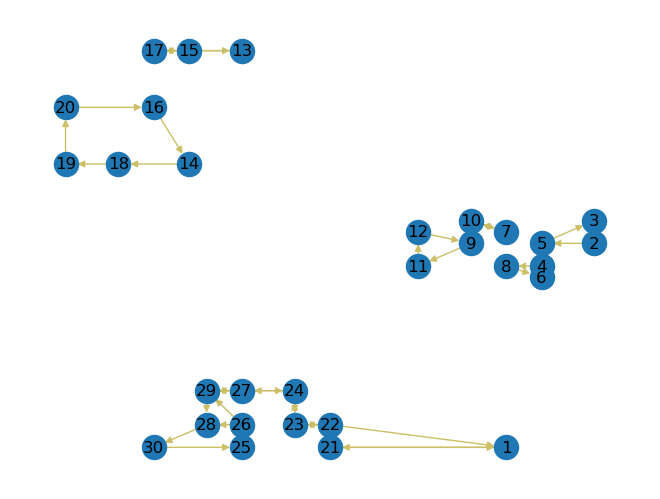

In [ ]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

# print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

not integer
21 1 0.5
21 22 0.5
22 1 0.5
22 23 0.5
23 22 0.5
23 24 0.5
24 23 0.5
24 27 0.5
26 28 0.5
26 29 0.5
27 24 0.5
27 29 0.5
29 27 0.5
29 28 0.5
minimal cycles [[10, 7]]
Optimal objective value: 106
Optimization time: 0.001 seconds


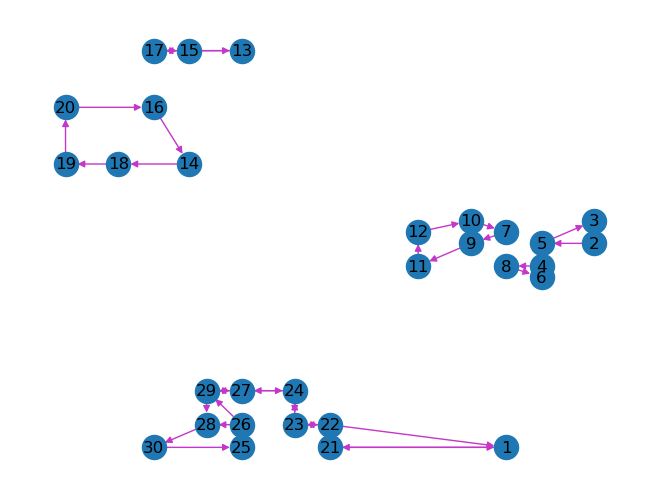

In [ ]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

not integer
21 1 0.5
21 22 0.5
22 1 0.5
22 23 0.5
23 22 0.5
23 24 0.5
24 23 0.5
24 27 0.5
26 28 0.5
26 29 0.5
27 24 0.5
27 29 0.5
29 27 0.5
29 28 0.5
minimal cycles [[5, 3, 2], [8, 6, 4], [17, 15, 13]]
Optimal objective value: 109
Optimization time: 0.0 seconds


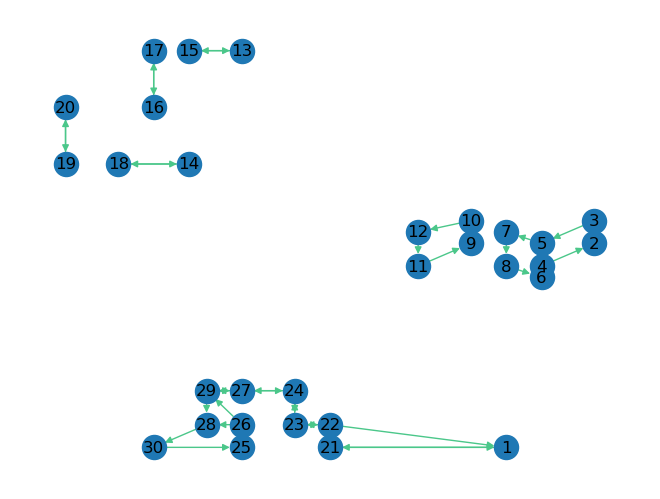

In [ ]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

not integer
21 1 0.5
21 22 0.5
22 1 0.5
22 23 0.5
23 22 0.5
23 24 0.5
24 23 0.5
24 27 0.5
26 28 0.5
26 29 0.5
27 24 0.5
27 29 0.5
29 27 0.5
29 28 0.5
minimal cycles [[15, 13], [17, 16], [18, 14], [20, 19]]
Optimal objective value: 112
Optimization time: 0.0 seconds


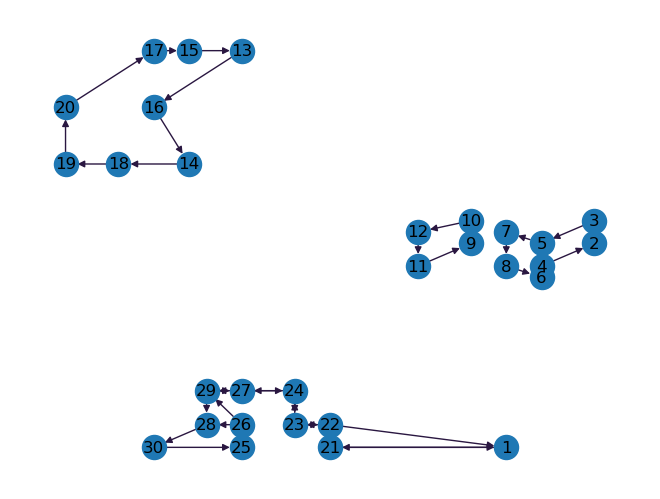

In [ ]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

not integer
21 1 0.5
21 22 0.5
22 1 0.5
22 23 0.5
23 22 0.5
23 24 0.5
24 23 0.5
24 27 0.5
26 28 0.5
26 29 0.5
27 24 0.5
27 29 0.5
29 27 0.5
29 28 0.5
minimal cycles [[12, 11, 9, 10]]
Optimal objective value: 112
Optimization time: 0.0 seconds


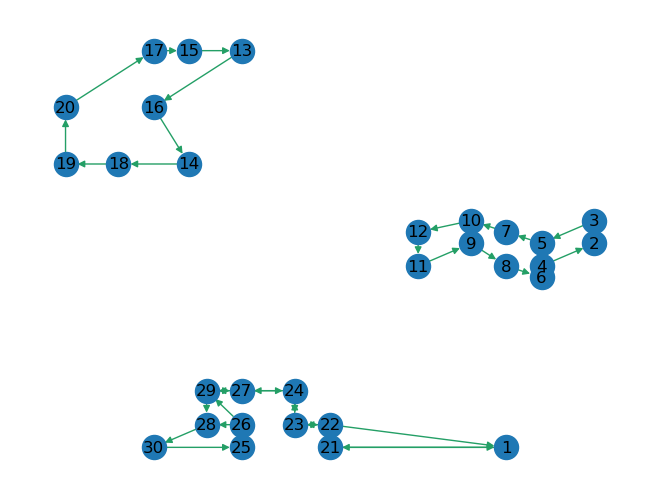

In [ ]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

not integer
21 1 0.5
21 22 0.5
22 1 0.5
22 23 0.5
23 22 0.5
23 24 0.5
24 23 0.5
24 27 0.5
26 28 0.5
26 29 0.5
27 24 0.5
27 29 0.5
29 27 0.5
29 28 0.5
minimal cycles [[20, 17, 15, 13, 16, 14, 18, 19]]
Optimal objective value: 131
Optimization time: 0.001 seconds


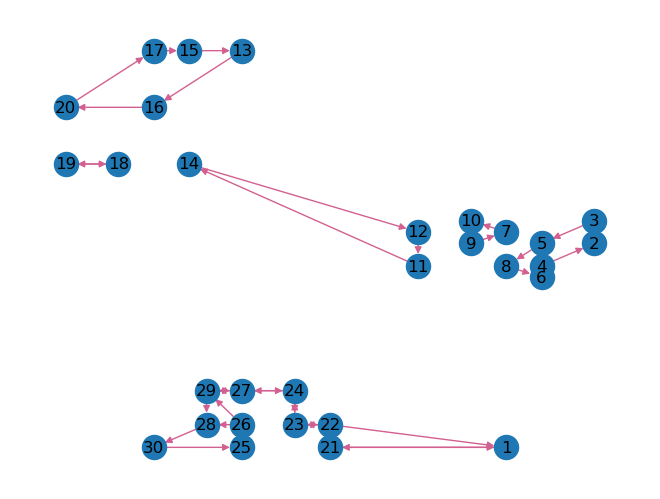

In [ ]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

not integer
21 1 0.5
21 22 0.5
22 1 0.5
22 23 0.5
23 22 0.5
23 24 0.5
24 23 0.5
24 27 0.5
26 28 0.5
26 29 0.5
27 24 0.5
27 29 0.5
29 27 0.5
29 28 0.5
minimal cycles [[19, 18]]
Optimal objective value: 132
Optimization time: 0.001 seconds


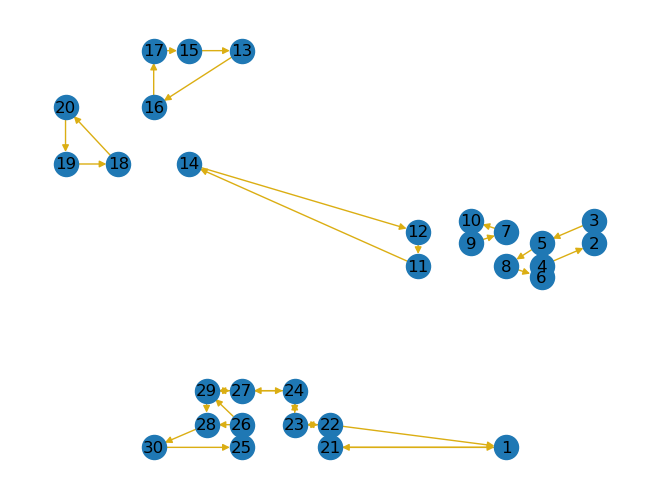

In [ ]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

not integer
21 1 0.5
21 22 0.5
22 1 0.5
22 23 0.5
23 22 0.5
23 24 0.5
24 23 0.5
24 27 0.5
26 28 0.5
26 29 0.5
27 24 0.5
27 29 0.5
29 27 0.5
29 28 0.5
minimal cycles [[10, 9, 7], [14, 12, 11], [20, 19, 18]]
Optimal objective value: 132
Optimization time: 0.001 seconds


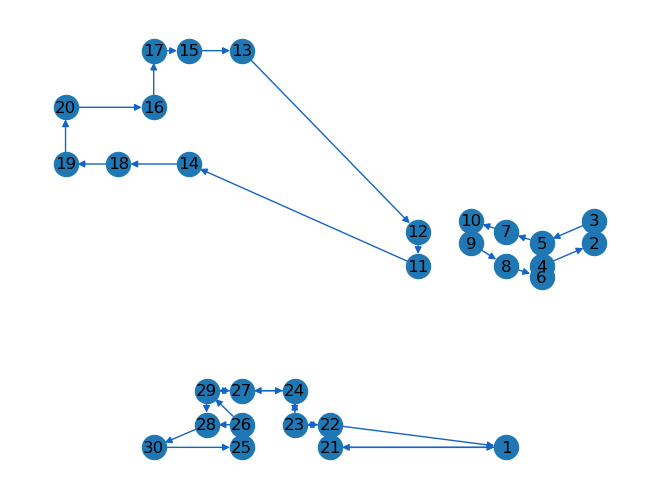

In [ ]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

not integer
21 1 0.5
21 22 0.5
22 1 0.5
22 23 0.5
23 22 0.5
23 24 0.5
24 23 0.5
24 27 0.5
26 28 0.5
26 29 0.5
27 24 0.5
27 29 0.5
29 27 0.5
29 28 0.5
minimal cycles [[10, 9, 8, 6, 4, 2, 3, 5, 7]]
Optimal objective value: 133
Optimization time: 0.001 seconds


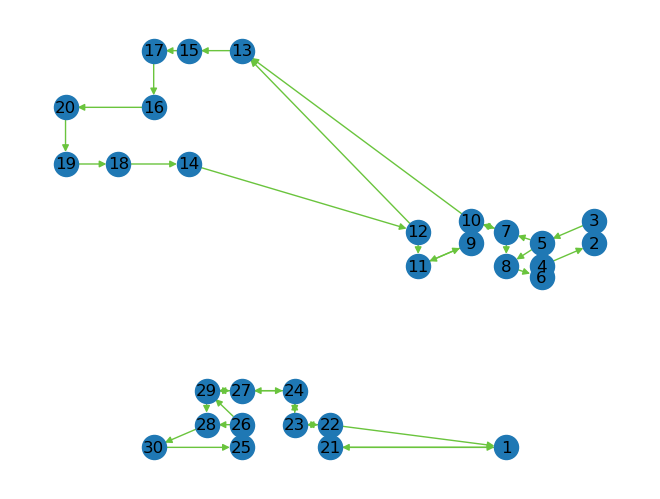

In [ ]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
if len(minimal_cycles) < n:
    for subset in minimal_cycles:
        m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)
        routing.solve_model(m)
        edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
        routing.show_tours([edges_used], locations, to_tikz = False)
else:
    print("done")

In [ ]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")

# VRP with Time Windows (VRPTW)

In [ ]:
num_vehicles  = 3
num_customers = 10
vehicle_capacity = 50

In [ ]:
instance = VRPInstance(data_file = 'data.dat', 
                    num_customers = num_customers,
                    num_vehicles = num_vehicles, 
                    depot = 1, 
                    vehicle_capacity = vehicle_capacity,
                    average_speed=1,
                    cost_per_mile=1)
vrptw = VRPModel(instance)
m = vrptw.get_gurobipy_model()
m.write("vrptw.lp")
routing.solve_model(m)

Optimal objective value: 118
Optimization time: 0.015 seconds


In [ ]:
#print("nodes", instance.nodes)
edges_used_list = []
for k in instance.vehicles:
    print("vehicle", k)
    edges_used_gurobi_vrptw = [(i, j) for i, j in instance.edges if m._x[i, j, k].x > 0.5]
    edges_used_list.append(edges_used_gurobi_vrptw)
    #print("edges used", edges_used_gurobi_vrptw)
    if len(edges_used_gurobi_vrptw) > 0:
        tour_vrptw = routing.get_tour_from_edges_used(edges_used_gurobi_vrptw)
        print("tour", tour_vrptw)
        # for i in tour_vrptw[:-1]:
        #     print("Node", i, "visited at time", m._t[i,k].x)
        # print("return time", m._return_time[k].x)

vehicle 0
tour [1, 9, 10, 7, 1]
vehicle 1
tour [1, 5, 3, 2, 1]
vehicle 2
tour [1, 6, 4, 8, 1]


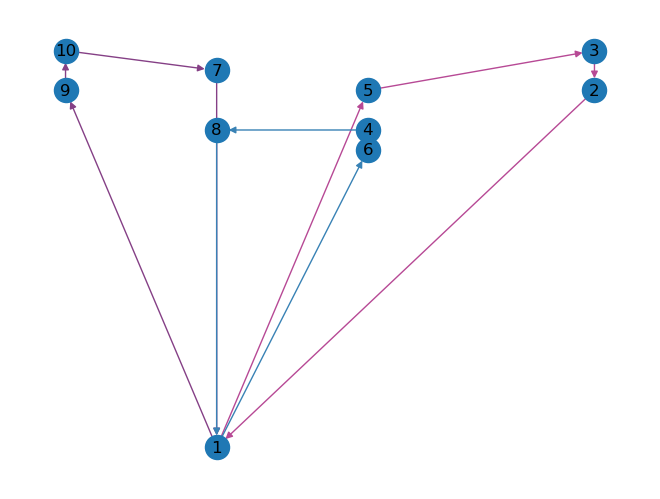

In [ ]:
routing.show_tours(edges_used_list, instance.locations, to_tikz = True,
                   num_vehicles = num_vehicles,
                   tikz_file_name = "vrptw.tex")

# VRPTW: Relaxation

In [ ]:
instance = VRPInstance(data_file = 'data.dat', 
                    num_customers = num_customers,
                    num_vehicles = num_vehicles, 
                    depot = 1, 
                    vehicle_capacity = vehicle_capacity,
                    average_speed=1,
                    cost_per_mile=1)
vrptw = VRPModel(instance)
m = vrptw.get_gurobipy_model(relaxed = True)
routing.solve_model(m)

Optimal objective value: 107
Optimization time: 0.001 seconds


In [ ]:
for k in instance.vehicles:
    print("vehicle", k)
    edges_used_adjacency_list= {i : {j : m._x[i, j,k].x for j in instance.nodes} for i in instance.nodes}
    for i in edges_used_adjacency_list:
        for j in edges_used_adjacency_list[i]:
            if edges_used_adjacency_list[i][j] > 0.01:
                print((i,j), edges_used_adjacency_list[i][j])

vehicle 0
(1, 6) 0.9999998672540497
(2, 3) 0.24987042705098295
(3, 2) 0.24987042705098295
(5, 7) 0.9998017639320225
(6, 1) 0.9999998672540495
(7, 5) 0.9998017639320225
vehicle 1
(1, 4) 0.9994817082039322
(4, 1) 0.9994817082039322
(9, 10) 0.999629
(10, 9) 0.999629
vehicle 2
(1, 8) 0.9994817082039322
(2, 3) 0.750129572949017
(3, 2) 0.750129572949017
(8, 1) 0.9994817082039322
